# Introduction
In `1. Exploring Spotify Track Data` I fetched Spotify track data using their Web API and did some exploratory data analysis. 
The tracks are fetched from two of my Daily mixes, one with American hiphop and one with Swedish pop.

In this notebook I intend to try out some clustering methods!

# Load the data

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [65]:
track_feature_df = pd.read_pickle('track_audio_features.pkl')

In [66]:
track_feature_df.head()

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence
0,Snart Skiner Poseidon,[Joel Alme],Snart Skiner Poseidon,Swedish Pop,0.828000,0.253,178978,0.482,0.000004,D,0.1530,-5.220,Major,0.0306,140.507,3,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.3490
1,"Svart, vitt och allt däremellan",[Daniel Adams-Ray],Vitt,Swedish Pop,0.485000,0.561,280653,0.666,0.004750,G,0.1270,-7.879,Major,0.0376,109.981,4,spotify:track:41L7xlhy4S63YFzBhJOlNU,0.3540
2,Kom hem som nån annan,[Emil Jensen],Längs hörnen,Swedish Pop,0.853000,0.400,260600,0.371,0.000686,C,0.3280,-11.405,Minor,0.0387,157.795,4,spotify:track:2Q8yH8RdEMLR56z9seHTjT,0.0899
3,Pantamera,[Familjen],Pantamera,Swedish Pop,0.000836,0.674,135000,0.865,0.002720,C,0.1650,-6.496,Major,0.0464,128.046,4,spotify:track:7I6yrk52OAtrGhjFhNhtrt,0.8260
4,...And Then There Was Timo,[Timo Räisänen],Creep,Swedish Pop,0.475000,0.351,194400,0.328,0.000000,G,0.0963,-7.606,Major,0.0335,104.426,1,spotify:track:4mdnleRe8GwP81gGWjolU6,0.0742


# K-Means
Let's start out with the basics.

K-means crates K clusters based on distance in the feature space. 
This makes it important to normalise all features.
Otherwise distances in one dimension will tend to be larger than another, making that dimension more influential.

Also, categorical variables can't be used.
This leaves me with three choices:<br><br>
**Treat the categoricals as ordinals and normalize their range**<br>
This has the major drawback of causing the distance between categoricals to vary depending on the new arbitrary order.
Take the categrical `Key` for example.
As mentioned in `1. Exploring Spotify Track Data` I don't want `C` to be treated as less than `G`, and I don't want `G` to be closer to `F` than `C`.
It is true that the keys are ordered, but I do not think this order is meaningful valuable when analysing a track.
<br><br>
** One-hot encode the categoricals** <br>
This would increase the number of dimensions by a lot, but most of these new dimensions would be 0. 
With the limited size of my data set, 95 track, the increase in number of dimensions wont be a problem in terms of added computational complexity.
The real problem is in the discreteness of the one-hot encoded features.
They are wither 0 or 1.
When meassuring the distance between two points, they either share the same categorical or they do not.
In the former case the  distance in that dimension will be 0, the very minimum, in the latter it is 1, the very maximum.
I think this will make the categorical variables much to influential.
<br><br>
As a toy example, consider using only two features, Key and Valence.
Lets measure the distance among three songs:
* Song 1
    * Key: C
    * Valence: 0.9
* Song 2
    * Key: G
    * Valence: 0.95
* Song 3
    * Key: G
    * Valence: 0.1

The pariwise distances among the songs would be calculated as:
    
|        | Song 1 | Song 2 | Song 3 |
|--------|--------|--------|--------|
| Song 1 |    0   |$$\sqrt{1 + 0.05^2}$$|$$\sqrt{1 + 0.8^2}$$|
| Song 2 |$$\sqrt{1 + 0.05^2}$$|   0    |$$\sqrt{0 + 0.85^2}$$|
| Song 3 |$$\sqrt{1 + 0.8^2}$$|$$\sqrt{0 + 0.85^2}$$|   0    |

To me it would seem that Song 1 and Song 2 should be seens as more close, as they are very close in Valence, but the categorical key feature is dominating the distance calculation.
Maybe this problem could be worked around by not setting the categoricals as [0, 1], but rather [0, x] with x as some smaller value, perhaps the mean value of all other features?
<br><br>
** Drop the categoricals** <br>
Bam, the easy solution.
The drawback is of course that I throw away information.

### Normalising the quantitative features

In [67]:
def minmax_scale(vec):
    max_val = vec.max()
    min_val = vec.min()
    
    return (vec - min_val) / (max_val - min_val)

In [68]:
quantitative_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'loudness', 'tempo', 'duration_ms']

In [69]:
normalised_df = track_feature_df.copy()
for col in quantitative_features:
    normalised_df[col] = minmax_scale(normalised_df[col])

In [70]:
normalised_df.head(1)

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence
0,Snart Skiner Poseidon,[Joel Alme],Snart Skiner Poseidon,Swedish Pop,0.843174,0.169607,0.35181,0.450055,0.000005,D,0.113516,0.837496,Major,0.009584,0.548811,3,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.328002


## Dropping the categoricals
I will start of with the simplest solution. I will just drop the categoricals.

In [71]:
from sklearn.cluster import KMeans

In [72]:
kmeans = KMeans(2)

In [73]:
X, y = normalised_df[quantitative_features].values, normalised_df[['name', 'playlist']]

In [74]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Let's see what the clusters look like!

In [75]:
clustered_df = normalised_df.copy()
clustered_df['cluster'] = kmeans.labels_

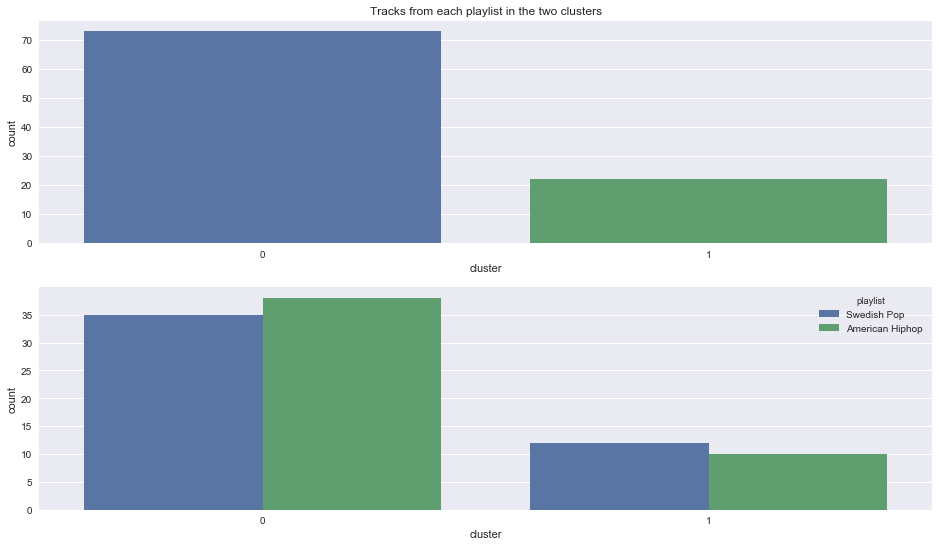

In [76]:
f, ax = plt.subplots(2, 1, figsize=(16,9))

sns.countplot(x='cluster', data = clustered_df,  ax=ax[0])
ax[0].set_title('Numer of tracks in the two clusters')

sns.countplot(x='cluster', hue = 'playlist',data=clustered_df, ax=ax[1])
ax[0].set_title('Tracks from each playlist in the two clusters')

The first cluster is much larger than the second. Also the clusters have a pretty even distribution of tracks from both playlist.

Maybe the clusters have some meaning, but they differ a lot from the clusters created by Spotify.

Let's also have a look at the box plots of the quantitative features.

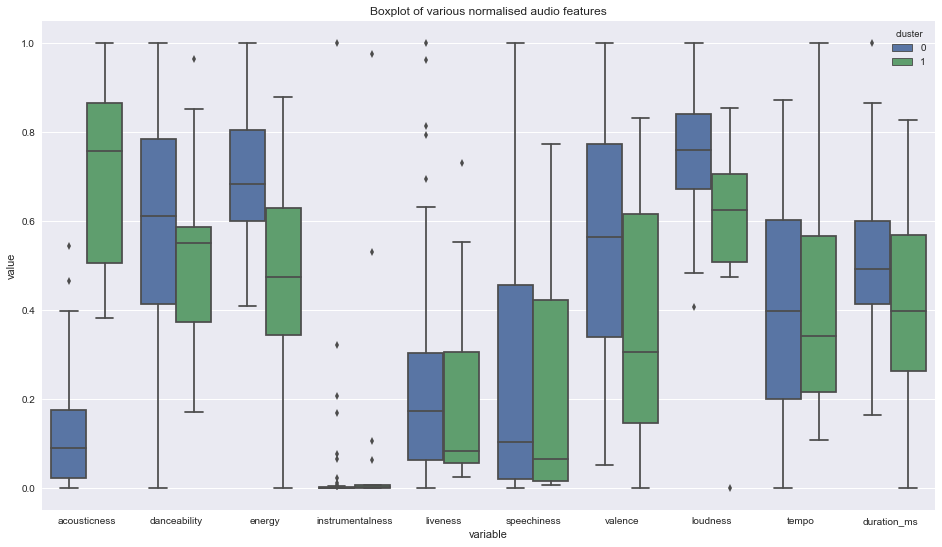

In [77]:
df = clustered_df.melt(id_vars = 'cluster', value_vars=quantitative_features)

f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x = 'variable', y='value', hue = 'cluster', data = df, ax=ax)
ax.set_title('Boxplot of various normalised audio features')

For acousticness, energy and valence the quartiles do not overlap at all between the two groups, for loudness they barely overlap.
Acoustincess is almost linearly separable between the two groups, only a couple of outliers from cluster 0 appear in the range of cluster 1.

It seems to me that some features have more influence on the clustering than others. 
This could be caused by a couple of factors, for example:
* I did normalization using MinMax scaling which can be heavily influenced by outliers.
* K-Means has not information about what features are useful, and has no possibility to adapt to labels as it is an unsupervised method. I must provide it with the features that I think are important for it to produce results that I deem meaningfull.

Let's try to adress my second point by only using the factors that I would like to cluster the songs with.

## Dropping more features
Let's try to get clusters that I would find useful!

Let's say I want a happy and energetic playlist, clustering with `Energy` and `Valence` might be a good idea! 
As I am doing clustering I also need to think about what other clusters should appear, lets try K=3 and see if I can get clusters representing the following groups of tracks:
* Happy and energetic tracks
* Tracks that are neither happy nor energetic
* Tracks somewher inbetween

In [78]:
X = quantitative_df[['energy', 'valence']].values

In [79]:
kmeans = KMeans(3)

In [80]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [81]:
clustered_df = normalised_df.copy()
clustered_df['cluster'] = kmeans.labels_

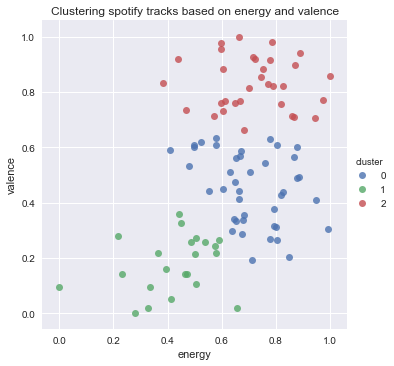

In [82]:
g = sns.lmplot(x='energy', y='valence', hue = 'cluster', data=clustered_df, fit_reg=False)
g.ax.set_title('Clustering spotify tracks based on energy and valence')

This is actually pretty cool! 

Separating tracks into different playlists is not easy as drawing lines between them typically feels very arbitrary. KMeans helped me draw these lines. To evaluate, lets have a look at the tracks in cluster 2.

In [92]:
clustered_df[clustered_df['cluster'] == 2]

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence,cluster
3,Pantamera,[Familjen],Pantamera,Swedish Pop,0.000831,0.740841,0.212996,0.870472,0.003067,C,0.127331,0.762339,Major,0.037114,0.456626,4,spotify:track:7I6yrk52OAtrGhjFhNhtrt,0.897350,2
6,Det kommer aldrig va över för mig,[Håkan Hellström],Du kan gå din egen väg,Swedish Pop,0.217907,0.781547,0.541685,0.754116,0.001623,A,0.039028,0.757333,Major,0.091131,0.545216,4,spotify:track:5TXBaxrLfOasUdn36cRQPN,0.881833,2
7,The Storm,[HOFFMAESTRO],The Storm,Swedish Pop,0.040408,0.538670,0.586087,0.828760,0.003033,F,0.031200,0.820827,Minor,0.111692,0.656561,4,spotify:track:6EJOWpdxctI8JIvmvEcE9Y,0.822153,2
11,Från där jag ropar,[Hästpojken],Jag ser solen i dig (Men den ser inte mig),Swedish Pop,0.000507,0.470828,0.414756,0.788145,0.000000,A,0.198711,0.745200,Major,0.014288,0.321756,4,spotify:track:6GKqsWnDfpkgFrftChVHcw,0.820960,2
13,Country,[Den svenska björnstammen],Hallå Livet,Swedish Pop,0.838082,0.852103,0.265393,0.467618,0.000791,E,0.059406,0.612263,Minor,0.015508,0.434233,4,spotify:track:4yQZFoU9aPXj9ycOyz1AIF,0.736214,2
17,Låter som miljarder,[bob hund],Darrande varulvshänder,Swedish Pop,0.361494,0.895522,0.223561,0.599341,0.320180,G,0.012088,0.681941,Major,0.053842,0.419001,5,spotify:track:4afUP39D8Dlast8vdvRKrw,0.977322,2
21,Pusselbitar,[Timbuktu],Allt grönt,Swedish Pop,0.107925,0.932157,0.582552,0.605928,0.000000,Bb,0.061708,0.537519,Minor,0.091479,0.478258,4,spotify:track:12jHYDhSTWMcOOqwSxnx01,0.883027,2
27,Satan i gatan (Bonus Version),[Veronica Maggio],Vi kommer alltid ha Paris,Swedish Pop,0.059248,0.686567,0.281766,0.819978,0.000449,F,0.536035,0.848510,Minor,0.019864,0.153003,4,spotify:track:3woptHfuKkrFvTqmCS9Mn7,0.755312,2
28,Evas story,[Doktor Kosmos],Doktor Knark Is Back In The Town,Swedish Pop,0.336035,0.736771,0.273600,0.890231,0.002649,C,0.276997,0.903817,Major,0.024046,0.539771,4,spotify:track:4oyFAJrZqKgECcZe2euA5m,0.941513,2
33,...Och Stora Havet,[Jakob Hellman],Tåg - 1998 Digital Remaster,Swedish Pop,0.070348,0.681140,0.404065,0.974753,0.000000,B,0.172231,0.731299,Major,0.014462,0.476882,4,spotify:track:4U8QAiTjj3cfmrXfflbcNo,0.772022,2


Looks pretty good, I recognize many of the songs as being both happy and energetic.

Of course these clusters do not take music genre in to account at all, so the schizophrenic nature of my data set leads to a playlist with both Hiphop and Pop. But sometimes this could be exactly what I want! A complete mix of songs I like, with the condition that they should have a certain mood!

In this case a simpler solution might have achieved similar results though. 
For example, if I just want happy and energetic tracks I could also have used a filter like "choose tracks above valence x and energy y".

Anyway, lets save this playlist so I can listen to it on Spotify!

In [85]:
import happify

In [90]:
import imp
imp.reload(happify)

<module 'happify' from 'C:\\Users\\Gustav\\Data Science\\Happify\\happify.py'>

In [ ]:
access_token = happify.authorize()

In [87]:
user_id = happify.get_user_id(access_token)

In [93]:
track_uris = list(clustered_df[clustered_df['cluster'] == 2]['uri'])
playlist_id = happify.create_playlist(access_token, user_id, "KMeans - Happy and Energetic")
r = happify.add_tracks_to_playlist(access_token, playlist_id, user_id, track_uris = track_uris)

**Lesson learned:** I think just mindlessly applying any clustering method to all features will result in clusters that I won't find very meaningful. An unsupervised method has no way of knowing what clusters I will find meaningful, so I must do careful feature engineering to ensure I get meaningful results.

# Finding meanigful features
Before trying any other clustering methods I want to find a useful set of features.

A method I have used a lot previously is PCA. 
PCA considers features with high variance more important. 
This might not be what I want when clustering, for example, I am not particularly interested in the duration of tracks but for all I know it could have high variance.

Let's try to achieve clustering similar to the playlist labels by doing dimensionality reduction using Linear Discriminant Analysis (LDA). 
This should give higher weight to features that separate the two playlist.

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [118]:
lda = LDA()

In [119]:
X, y = normalised_df[quantitative_features].values, normalised_df['playlist']

In [120]:
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [122]:
X_transformed = lda.transform(X)

In [126]:
reduced_df = normalised_df.copy()
reduced_df['LDA Value'] = X_transformed

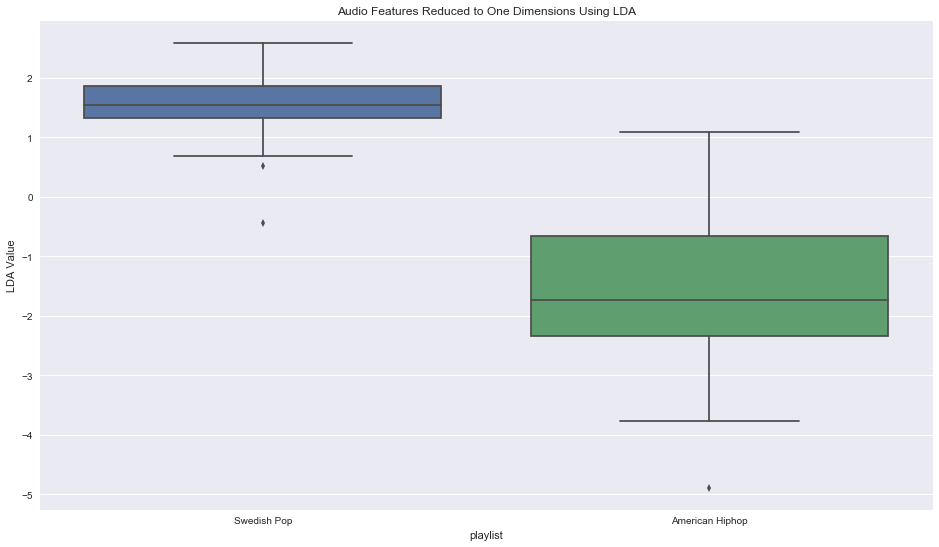

In [135]:
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x='playlist', y='LDA Value', data=reduced_df)
ax.set_title('Audio Features Reduced to One Dimensions Using LDA')

The data is now reduced to one dimension, where the two playlists are almost linearly separable.

Let's have a look at what features LDA found to correspond to each class.
Features scaled with a large positive value are associated with `Swedish Pop`, and features with large negative values are associated with `American Hiphop`.

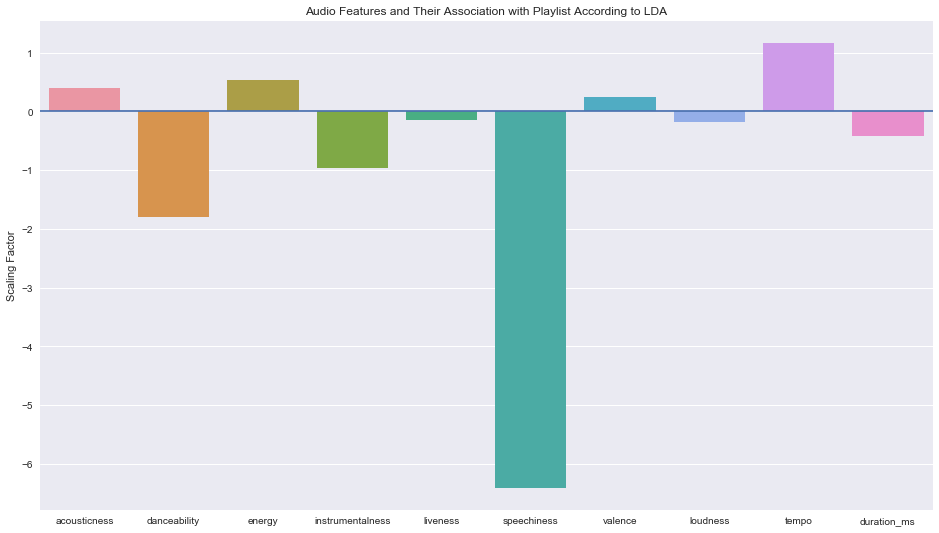

In [153]:
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x = quantitative_features, y = lda.scalings_.flatten(), ax=ax)
ax.axhline(0)
ax.set_title('Audio Features and Their Association with Playlist According to LDA')
ax.set_ylabel('Scaling Factor')

Positive `speechiness` is highy associated with Rap as expected, and is by far the most important feature used to distinguish tracks from the two playlists.

Other important features are `danceability`, `tempo` and `instrumentalness`, though the large value given to `instrumentalness` is probably due to most values being close to 0 with some outliers affecting the normalised value.

Still, even though these features do a good job of separating these two specific playlists, they are not really the features I am looking at first when choosing what tracks I feel like listening to.

When Spotify crates Daily Mixes for me I suspect they don't apply clustering based on audio features on their whole set of tracks. 
It seems more likely that they would reduce the possible tracks with simpler methods first, and possibly apply clustering to the audio features at a later stage.

For simplicity, consider my list of 95 tracks as all tracks in the Spotify music library.
To create relevant playlist based on this library, I would probably start of by looking at a more high level grouping of tracks such as genre. 
This is not available in the track data I fetched, but I imagine Spotify have these kind of tags for all tracks.
I would limit a playlist to just one genre or combination of genres.
I would then apply clustering on only tracks from this genre to try to find subgroups of similar tracks.

Lets try this approach to find an arbitrary number of subgroups inside the `Swedish Pop` playlist.

# DBSCAN
Lets use DBSCAN to find an unspecified number of clusters in the `Swedish Pop` playlist.

In [223]:
swedish_pop = normalised_df.loc[normalised_df['playlist'] == 'Swedish Pop']

In [154]:
from sklearn.cluster import DBSCAN

## All quantitative featutres

In [226]:
X = swedish_pop.loc[:,quantitative_features].values

To find a good value of epsilon I should have a look at what the distances in X look like.

In [227]:
from sklearn.metrics import pairwise

In [228]:
distances = pairwise.euclidean_distances(X)

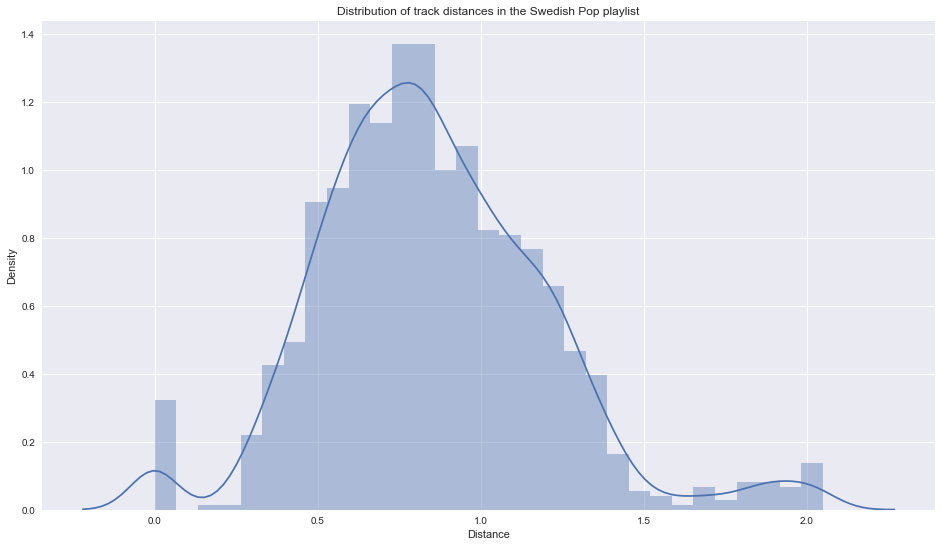

In [229]:
f, ax = plt.subplots(figsize=(16,9))
sns.distplot(distances.flatten(), ax=ax)
ax.set_title('Distribution of track distances in the Swedish Pop playlist')
ax.set_ylabel('Density')
ax.set_xlabel('Distance')

Lets try epsilon around .4, I don't want to many points to be considered neighbours.

In [230]:
dbscan = DBSCAN(eps = .4, min_samples=3)

In [231]:
labels = dbscan.fit_predict(X)

In [232]:
labels

array([-1, -1, -1,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0, -1, -1,  0,  0,
       -1, -1, -1,  0,  0, -1,  0,  0,  1, -1,  0, -1,  0,  0, -1,  1,  0,
        0,  1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1], dtype=int64)

In [239]:
clustered_df = swedish_pop.copy()
clustered_df['cluster'] = labels
clustered_df['cluster'] = clustered_df['cluster'].astype(float).replace(-1, np.nan)

In [243]:
print("{} tracks did not get assigned a cluster".format(clustered_df['cluster'].isnull().sum()))

18 tracks did not get assigned a cluster


18 tracks did not get assigned a cluster. I could change this value by tweaking the epsilon and minimum_samples parameters of DBSCAN, but it does not really matter that some tracks don't find a cluster.

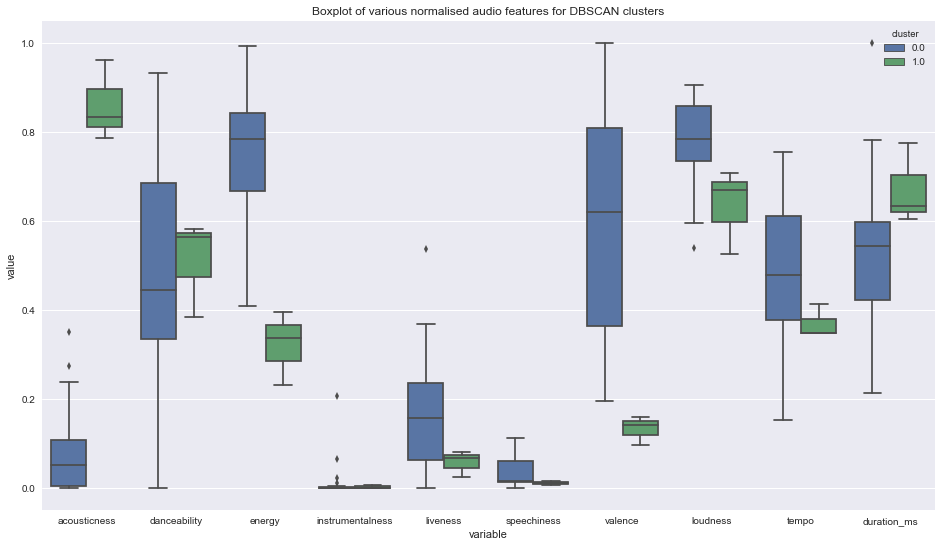

In [244]:
df = clustered_df.melt(id_vars = 'cluster', value_vars=quantitative_features)

f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x = 'variable', y='value', hue = 'cluster', data = df, ax=ax)
ax.set_title('Boxplot of various normalised audio features for DBSCAN clusters')

In [245]:
clustered_df[clustered_df['cluster'] == 1.0]

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence,cluster
25,Så mycket Bo Kaspers Orkester,[Bo Kaspers Orkester],Vi kommer aldrig att dö - 2009 Version,Swedish Pop,0.832991,0.582090,0.774378,0.335895,0.006077,F,0.078978,0.670044,Minor,0.014288,0.346797,4,spotify:track:4hbijkxB7YcmzjMBUGGR09,0.095249,1.0
32,Moto Boy,[Moto Boy],Beat heart,Swedish Pop,0.960284,0.564450,0.604729,0.231614,0.000112,C#,0.066314,0.524384,Minor,0.009409,0.412372,4,spotify:track:6WbIf3CGwLDJtDqOVn7OV4,0.140606,1.0
35,Däggdjur,[Säkert!],Allting flyter,Swedish Pop,0.786146,0.382632,0.632297,0.395170,0.000000,C,0.022795,0.706208,Major,0.006796,0.347456,4,spotify:track:26mg5XX5LBvXLRDtF3gvMB,0.159704,1.0


So this is the small cluster. 
All three songs are quite melancholic, reflected by their low valence.
However, I would say Bo Kaspers Orkester's Vi kommer aldrig att dö is the least melancholic of the three, though it's valence is the lowest.
Spotify's definition of valence might not completely match my expectation.
To evaluate the features properly I would need to explore them in more detail, perhaps by putting them in relation to some songs I know well.
I will leave this for another time though.

Let's try to reduce the number of features again, as I am not very happy with this first set of clusters.

## Fewer features

Again, I will try to reduce the feature set to features I am interested in. Let's start with just Valence and Energy.

In [247]:
X = swedish_pop.loc[:,['valence', 'energy']].values

To find a good value of epsilon I should have a look at what the distances in X look like.

In [248]:
distances = pairwise.euclidean_distances(X)

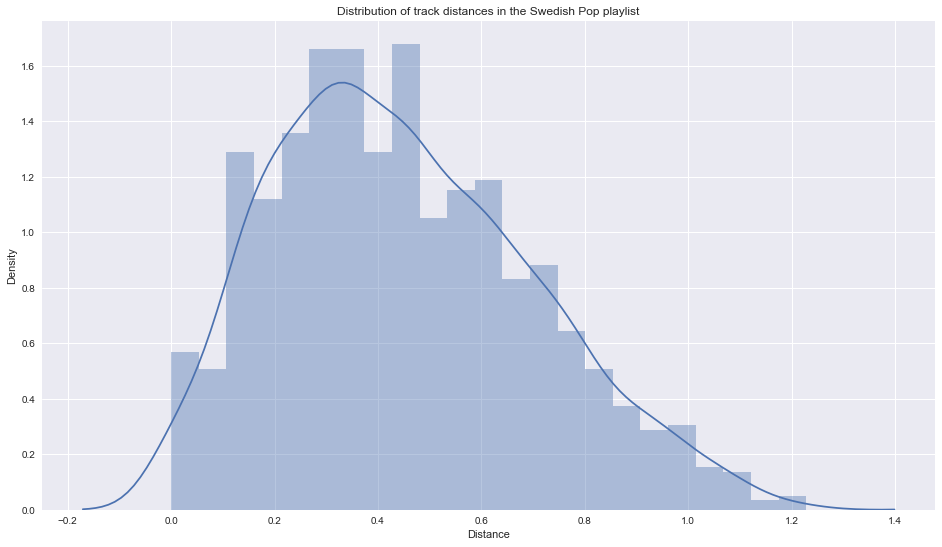

In [249]:
f, ax = plt.subplots(figsize=(16,9))
sns.distplot(distances.flatten(), ax=ax)
ax.set_title('Distribution of track distances in the Swedish Pop playlist')
ax.set_ylabel('Density')
ax.set_xlabel('Distance')

Lets try epsilon around .1, I don't want to many points to be considered neighbours.

In [283]:
dbscan = DBSCAN(eps = .12, min_samples=3)

In [284]:
labels = dbscan.fit_predict(X)

In [285]:
labels

array([ 0,  1,  2,  3,  2,  4,  3,  3,  0,  1, -1,  3,  1, -1,  0,  3,  1,
        3,  2,  1,  1,  3,  1,  0,  0,  2,  0,  3,  3,  4, -1,  2,  2,  3,
        1,  2, -1,  3,  1,  3,  1,  3,  3,  3,  1,  1,  4], dtype=int64)

In [286]:
clustered_df = swedish_pop.copy()
clustered_df['cluster'] = labels
clustered_df['cluster'] = clustered_df['cluster'].astype(float).replace(-1, np.nan)

In [287]:
print("{} tracks did not get assigned a cluster".format(clustered_df['cluster'].isnull().sum()))

4 tracks did not get assigned a cluster


4 tracks did not get assigned a cluster. I could change this value by tweaking the epsilon and minimum_samples parameters of DBSCAN, but it does not really matter that some tracks don't find a cluster.

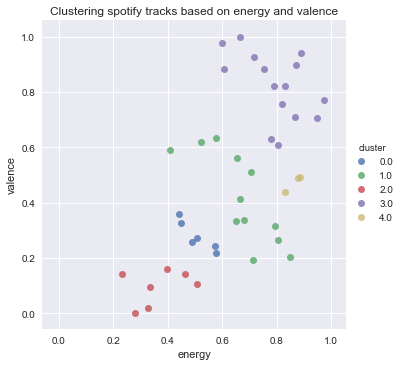

In [288]:
g = sns.lmplot(x='energy', y='valence', hue = 'cluster', data=clustered_df, fit_reg=False)
g.ax.set_title('Clustering spotify tracks based on energy and valence')

In [289]:
clustered_df[clustered_df['cluster'] == 0.0]

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence,cluster
0,Snart Skiner Poseidon,[Joel Alme],Snart Skiner Poseidon,Swedish Pop,0.843174,0.169607,0.351810,0.450055,0.000005,D,0.113516,0.837496,Major,0.009584,0.548811,3,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.328002,0.0
8,En apa som liknar dig,[Olle Ljungström],Med eller utan,Swedish Pop,0.050083,0.799186,0.448552,0.442371,0.000386,D,0.064011,0.580869,Major,0.000697,0.236813,4,spotify:track:4pNq7S5IEuud8fJ8SSMMCa,0.360229,0.0
14,Allting som vi sa,[Ida Redig],Allting som vi sa,Swedish Pop,0.175136,0.523745,0.346829,0.574094,0.000000,E,0.032006,0.601013,Major,0.033630,0.589662,4,spotify:track:6cUEmMGO2aOrjGtqiWGL61,0.242063,0.0
23,Somebody Outside,[Anna Ternheim],Better Be,Swedish Pop,0.083485,0.426052,0.587769,0.488474,0.000061,C,0.174534,0.741194,Minor,0.000000,0.252290,4,spotify:track:4A7WgqK0eTfvsPbZC8TG9e,0.258773,0.0
24,Svart blogg (Deluxe Edition),[Eldkvarn],Fulla för kärlekens skull,Swedish Pop,0.350292,0.324288,1.000000,0.577387,0.000003,E,0.126180,0.859819,Major,0.014114,0.433138,4,spotify:track:3myN8VIQbnMGr9qHiczMcf,0.218190,0.0
26,Orka då,[Emil Jensen],Sudditjuven,Swedish Pop,0.539706,0.546811,0.394513,0.506037,0.000003,F,0.050196,0.599305,Minor,0.009584,0.278567,4,spotify:track:2GyqOkWjGqCb79YrgYdRN4,0.270709,0.0


The clusters get progressively more energetic and happy. 
Pretty cool!

I think finding the right epsilon for your data is crucial to get resonable results with DBSCAN, iterating unti you find one you like is easy in a low number of dimensions, but challenging for 4+. 

It would be interesting to apply clustering to a larger, somwhat coherent, playlist to try to identify subgroups.

# Summary
I have tried out KMeans and DBSCAN on the quantitative features of the spotify track data.
It was hard to verify the meaningfulness of clusters created when using many features, and to achieve a clustering similar to the playlist labels I would most likely have to compromise on my choice of features. 
Using Linear Discriminant Analysis I showed that the two features were almost linearly separable, but the choice of features favoured features would not be very interesting for providing nuanced playlists.

To solve the problem of building playlists bound to a specific genre, but also with a coherent feel in other respects such as happines, danciness etc. I suggest doing two or more stages of clustering.
The first one could be very simple, like classifying genre using meta data or a clustering model.
Then a second clustering model could be applied to figure out more subtle subgroups.

Perhaps testing out clustering on multidimensional track data was not the best way of getting a feel for the effectiveness of different clustering models, but it was enjoyable to work with the Spotify data.